<table>
    <tr>
        <td>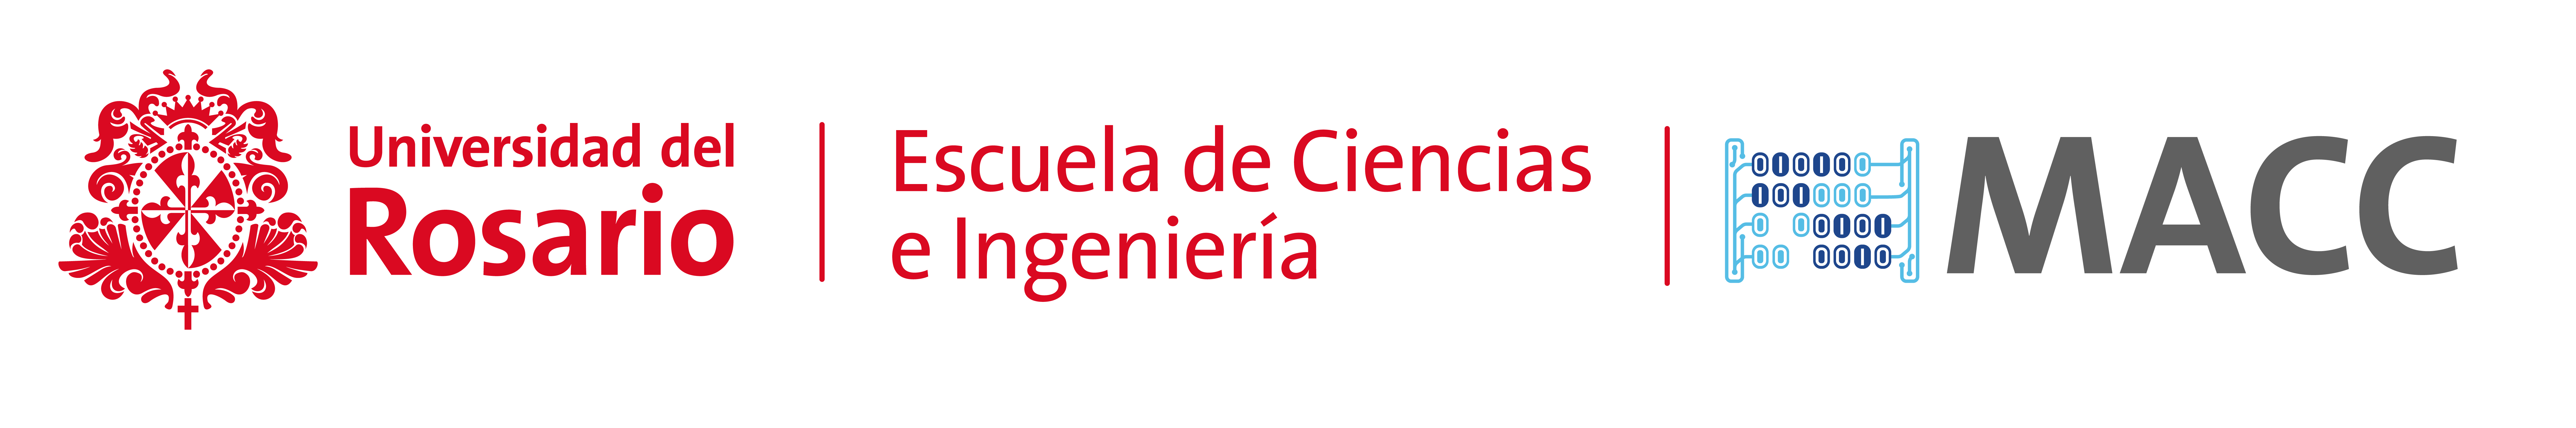</td>
        <td>&nbsp;</td>
        <td>
            <h1 style="font-size:200%;text-align:center">   KNNs         </h1></td>         
        <td>
            <tp><p style="font-size:99%;text-align:center">Aprendizaje Automático de Máquina </p></tp>
            <tp><p style="font-size:80%;text-align:center">Maestría MACC 2025-2</p></tp>
            <tp><p style="font-size:80%;text-align:center">Prof. Luis E. Seijas</p></tp>
        </td>
    </tr>
</table>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# KNNs

Este es el plan de acción para nuestro preprocesamiento:

1. **Estandarización de Nombres**: Lo primero será limpiar los nombres de las columnas. Convertiremos todos los nombres al formato snake_case (por ejemplo, Claim Amount se convertirá en claim_amount) para facilitar el acceso y la manipulación de las variables.

2. **Tratamiento de Problemas Críticos**:

* Claim Amount: Reemplazaremos el valor centinela -99999 por un valor nulo (NaN) para que no afecte nuestros cálculos estadísticos.

* Marital Status: Eliminaremos esta columna por completo, ya que la alta proporción de valores faltantes (66%) la hace poco fiable para el análisis.

3. **Corrección de Problemas de Prioridad Alta y Media**:

* Income of Policy Holder: Asumiremos que el valor 0 significa "no informado" y lo reemplazaremos por NaN. Esto nos permitirá tratarlo como un valor faltante.

* Redundancia (Total Claimed y Num Claims): Para evitar la multicolinealidad, eliminaremos la columna Total Claimed, ya que está fuertemente correlacionada con Num Claims.

* % Soft Tissue: Investigaremos sus valores únicos. Dado que parece ser una variable discreta, la trataremos como una variable categórica en lugar de un porcentaje numérico continuo.

4. **Manejo de Valores Faltantes (Baja Prioridad)**:

* Num Soft Tissue: Imputaremos el 2% de valores faltantes utilizando la mediana, que es una medida robusta y adecuada para este tipo de dato.

5. **Ingeniería de Características (Paso Inicial)**:

* Consideraremos la creación de variables derivadas. Un buen punto de partida, una vez que los datos estén limpios, será analizar las interacciones entre variables, como la frecuencia de ciertos tipos de lesiones (Injury Type), que ya has identificado como un predictor importante.

In [ ]:
# importar librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# --- 1. Carga de Datos ---
# Cargamos el conjunto de datos desde el archivo CSV.
try:
    df = pd.read_csv('AQUI VA LA RUTA AL ARCHIVO')
    print("Datos cargados correctamente.")
    print("Forma inicial del DataFrame:", df.shape)
    print("-" * 50)
except FileNotFoundError:
    print("Error: Archivo 'MotorInsuranceFraudClaimABTFull.csv' no encontrado.")
    print("Asegúrate de que el archivo esté en el mismo directorio que tu notebook.")
    df = None

if df is not None:
    # --- 2. Estandarización de Nombres de Columnas ---
    # Convertimos todos los nombres de columna a formato snake_case para consistencia.
    # Ejemplo: 'Claim Amount' -> 'claim_amount'
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('%', 'percent')
    print(" Nombres de columnas estandarizados a snake_case.")
    print("Nuevos nombres:", df.columns.tolist())
    print("-" * 50)

    # --- 3. Tratamiento de Problemas Críticos ---
    # Reemplazamos el valor centinela -99999 en 'claim_amount' por NaN (Not a Number).
    df['claim_amount'] = df['claim_amount'].replace(-99999, np.nan)
    print(f" Reemplazados {-99999} en 'claim_amount' por NaN.")

    # Eliminamos la columna 'marital_status' debido al alto porcentaje (66%) de valores faltantes.
    if 'marital_status' in df.columns:
        df.drop(columns=['marital_status'], inplace=True)
        print("Columna 'marital_status' eliminada.")
    else:
        print(" La columna 'marital_status' no se encontró para eliminar.")
    print("-" * 50)

    # --- 4. Corrección de Problemas de Prioridad Alta y Media ---
    # Eliminamos 'income_of_policy_holder' para evitar multicolinealidad con 'num_claims'.
    if 'income_of_policy_holder' in df.columns:
        df.drop(columns=['income_of_policy_holder'], inplace=True)
        print("Columna 'income_of_policy_holder' eliminada")
    else:
         print("La columna 'total_claimed' no se encontró para eliminar.")

    # Eliminamos 'total_claimed' para evitar multicolinealidad con 'num_claims'.
    if 'total_claimed' in df.columns:
        df.drop(columns=['total_claimed'], inplace=True)
        print("Columna 'total_claimed' eliminada por redundancia.")
    else:
         print("La columna 'total_claimed' no se encontró para eliminar.")

    # Investigamos la columna 'percent_soft_tissue' que ahora es 'percent_soft_tissue'.
    # Sus valores parecen discretos, no un porcentaje real.
    print("Valores únicos en 'percent_soft_tissue':", df['percent_soft_tissue'].unique())
    print("-" * 50)

    # --- 5. Manejo de Valores Faltantes (Baja Prioridad) ---
    # Imputamos los valores faltantes en 'num_soft_tissue' con la mediana.
    median_num_soft_tissue = df['num_soft_tissue'].median()
    df['num_soft_tissue'] = df['num_soft_tissue'].fillna(median_num_soft_tissue)
    print(f"Valores faltantes en 'num_soft_tissue' imputados con la mediana ({median_num_soft_tissue}).")
    print("-" * 50)

    # --- 6. Verificación Final ---
    print("\nResumen del DataFrame después del preprocesamiento:\n")
    df.info()

    print("\n\n Primeras 5 filas del DataFrame limpio:\n")
    print(df.head())

In [ ]:
df

## Ingeniería de Características: Creando Valor a partir de los Datos
La ingeniería de características (o feature engineering) es el arte y la ciencia de crear nuevas variables predictoras (features) a partir de las que ya existen. El objetivo es darle al modelo información más relevante y con mayor poder predictivo. Veamos las ideas que propusiste:

* Frecuencias de Reclamaciones:

    * ¿Qué es?: Consiste en calcular la frecuencia con la que aparece una categoría dentro de una variable. Por ejemplo, podríamos calcular qué tan común es el injury_type. Si "Soft Tissue" es muy frecuente en casos de fraude, esta frecuencia podría ser una señal para el modelo.

    * ¿Cómo se implementa?: Se agrupan los datos por la categoría de interés (p. ej., injury_type) y se calcula la media del fraud_flag. El resultado es una nueva variable que asigna a cada tipo de lesión su "tasa de fraude" histórica.

* Número de Reclamaciones por Tiempo de Vida:

    * ¿Qué es?: Esta métrica mide la "velocidad" con la que un asegurado realiza reclamaciones. Un cliente que reclama muy a menudo en un corto periodo de tiempo podría ser sospechoso.

    * Limitación en nuestros datos: Nuestro conjunto de datos parece ser una "fotografía" en el tiempo; no tenemos fechas ni un historial del cliente para calcular esta métrica directamente. Sin embargo, podemos crear un proxy.

* Relación entre Número de Reclamaciones y Pagos:

    * ¿Qué es?: Se trata de crear ratios que pongan en contexto las variables. Un número alto de reclamaciones no significa lo mismo para un pago total de $100 que para uno de $100,000.

    * Ejemplo práctico: Podemos crear una variable paid_to_claimed_ratio dividiendo claim_amount_received entre claim_amount. Un ratio muy bajo (se reclama mucho, se recibe poco) o muy alto podría ser un patrón interesante.

**Plan de Acción para el Siguiente Bloque de Código**
* Imputación final: Rellenaremos el valor nulo restante en claim_amount.

* Ingeniería de Característica (Ratio): Crearemos la variable paid_to_claimed_ratio como ejemplo práctico.

* Codificación de Variables Categóricas: Usaremos One-Hot Encoding para convertir insurance_type, injury_type y overnight_hospital_stay a formato numérico. Esto crea nuevas columnas binarias (0 o 1) para cada categoría, evitando que el modelo asuma un orden inexistente entre ellas.

* División de Datos (X, y): Separaremos nuestras variables predictoras (X) de nuestra variable objetivo (y, que es fraud_flag).

* Escalado de Características: Aplicaremos StandardScaler a todas las variables en X. Esto las transformará para que tengan una media de 0 y una desviación estándar de 1, lo cual es esencial para que KNN funcione correctamente, ya que es muy sensible a la escala de las variables.

* División en Entrenamiento y Prueba: Dividiremos los datos en un conjunto para entrenar el modelo y otro para evaluarlo.



In [ ]:
if df is not None:
    # --- 1. Imputación Final ---
    if df['claim_amount'].isnull().any():
        claim_amount_median = df['claim_amount'].median()
        df['claim_amount'] = df['claim_amount'].fillna(claim_amount_median)

    # --- 2. Ingeniería de Características ---
    epsilon = 1e-6
    # Guardamos los nombres de las columnas numéricas originales ANTES de modificarlas.
    numeric_cols_original = df.select_dtypes(include=np.number).drop(columns=['id', 'fraud_flag']).columns.tolist()

    df['paid_to_claimed_ratio'] = df['claim_amount_received'] / (df['claim_amount'] + epsilon)
    df.drop(columns=['claim_amount_received', 'claim_amount'], inplace=True)
    # Actualizamos la lista de columnas numéricas
    numeric_cols_original.remove('claim_amount_received')
    numeric_cols_original.remove('claim_amount')
    numeric_cols_original.append('paid_to_claimed_ratio')


    # --- 3. Codificación de Variables Categóricas (One-Hot Encoding) ---
    categorical_cols = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # --- 4. División de Datos (X, y) ---
    X = df.drop(columns=['fraud_flag', 'id'])
    y = df['fraud_flag']

    # --- 5. División en Conjuntos de Entrenamiento y Prueba ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # --- 6. Escalado de Características (Versión Corregida) ---
    print("✅ Iniciando escalado selectivo de características.")

    # Identificamos las columnas categóricas (one-hot) en el DataFrame final X
    # Serán todas las columnas que no estaban en nuestra lista numérica original.
    categorical_cols_final = [col for col in X.columns if col not in numeric_cols_original]

    # Instanciamos el escalador
    scaler = StandardScaler()

    # --- Escalado del conjunto de ENTRENAMIENTO ---
    # Ajustamos y transformamos SÓLO las columnas numéricas de entrenamiento
    X_train_num_scaled = scaler.fit_transform(X_train[numeric_cols_original])
    # Convertimos el resultado a DataFrame para mantener los nombres de las columnas
    X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, index=X_train.index, columns=numeric_cols_original)
    # Extraemos las columnas categóricas (sin escalar)
    X_train_cat = X_train[categorical_cols_final]
    # Unimos las numéricas escaladas y las categóricas
    X_train_scaled = pd.concat([X_train_num_scaled_df, X_train_cat], axis=1)

    # --- Escalado del conjunto de PRUEBA ---
    # Transformamos SÓLO las columnas numéricas de prueba con el escalador ya ajustado
    X_test_num_scaled = scaler.transform(X_test[numeric_cols_original])
    # Convertimos a DataFrame
    X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, index=X_test.index, columns=numeric_cols_original)
    # Extraemos las columnas categóricas
    X_test_cat = X_test[categorical_cols_final]
    # Unimos todo
    X_test_scaled = pd.concat([X_test_num_scaled_df, X_test_cat], axis=1)

    print("✅ Características numéricas escaladas. Las categóricas permanecen como 0s y 1s.")
    print("\n👀 Primeras 5 filas de los datos de entrenamiento procesados correctamente:\n")
    print(X_train_scaled.head())

In [ ]:
X_train_scaled

## Implementación de KNN desde Cero (Brute-Force)
La versión "brute-force" o de búsqueda exhaustiva de KNN es la más intuitiva. Para clasificar un nuevo punto de datos (un nuevo reclamo de seguro), el algoritmo sigue estos pasos:

1. **Calcular la Distancia**: Mide la distancia entre el nuevo reclamo y todos y cada uno de los reclamos en nuestro conjunto de datos de entrenamiento.

2. **Encontrar los Vecinos**: Ordena todas esas distancias de menor a mayor y se queda con los k reclamos más cercanos (los "k-vecinos"). k es un número que nosotros definiremos (por ejemplo, 5).

3. **Votar por la Clase**: Mira la etiqueta (fraud_flag) de esos k vecinos. La predicción para el nuevo reclamo será la etiqueta que aparezca con más frecuencia (la moda). Si 3 de los 5 vecinos más cercanos son fraudulentos, el nuevo reclamo se clasificará como fraude.



In [ ]:
# --- Implementar la Distancia Euclidiana ---
# Esta es una función auxiliar que calcula la distancia en línea recta
# entre dos puntos de datos (vectores).

def euclidean_distance(x1, x2):
    """
    Calcula la distancia euclidiana entre dos vectores.

    Args:
        x1 (np.array): El primer vector de características.
        x2 (np.array): El segundo vector de características.

    Returns:
        float: La distancia euclidiana.
    """
    return np.sqrt(np.sum((x1 - x2)**2))


# --- Crear la Clase KNN ---
# Esta clase contendrá toda la lógica de nuestro clasificador.

class KNN:
    """
    Clase para el clasificador K-Vecinos más Cercanos (KNN) desde cero.
    """
    def __init__(self, k=3):
        """
        Inicializador de la clase.

        Args:
            k (int): El número de vecinos a considerar.
        """
        # Guardamos el hiperparámetro 'k'
        self.k = k

    def fit(self, X, y):
        """
        "Entrena" el clasificador. Para KNN, esto es muy simple:
        solo memoriza los datos de entrenamiento.

        Args:
            X (np.array): Las características de entrenamiento.
            y (np.array): Las etiquetas de entrenamiento.
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        """
        Realiza predicciones para un conjunto de datos X.

        Args:
            X (np.array): Los datos para los que se quiere predecir.

        Returns:
            list: Una lista con las predicciones para cada punto en X.
        """
        # Aplicamos el método de predicción a cada una de las filas en X.
        predictions = [self._predict_one(x) for x in X]
        return np.array(predictions)

    def _predict_one(self, x):
        """
        Predice la clase para un único punto de datos 'x'.

        Args:
            x (np.array): Un solo vector de características a clasificar.

        Returns:
            int: La clase predicha (0 o 1).
        """
        # 1. Calcular la distancia entre 'x' y todos los puntos en X_train.
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]

        # 2. Obtener los 'k' vecinos más cercanos.
        # Usamos np.argsort para obtener los índices de las distancias más pequeñas.
        k_nearest_indices = np.argsort(distances)[:self.k]

        # 3. Extraer las etiquetas de esos vecinos.
        k_nearest_labels = [self.y_train.iloc[i] for i in k_nearest_indices]

        # 4. Votar por la clase más común.
        # Counter().most_common(1) nos da una tupla (valor, conteo).
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

## Entrenamiento y Evaluación del Modelo

En este paso, realizaremos el ciclo completo de machine learning:

1. **Instanciación**: Crearemos un objeto de nuestra clase KNN, eligiendo un valor inicial para k. Un valor común para empezar es 5.

2. **Entrenamiento**: Alimentaremos el modelo con los datos de entrenamiento escalados (X_train_scaled y y_train).

3. **Predicción**: Usaremos el modelo entrenado para predecir si los reclamos en el conjunto de prueba (X_test_scaled) son fraudulentos o no.

4. **Evaluación**: Compararemos nuestras predicciones con las etiquetas reales (y_test) para medir el rendimiento.



### Métricas de Evaluación

**La Matriz de Confusión**
Imagina una tabla que compara las predicciones de nuestro modelo con los resultados reales. Esta tabla tiene 4 casillas que nos dicen los 4 posibles resultados de una predicción. En nuestro caso, la "clase positiva" es el Fraude (1).

* Verdadero Positivo (TP - True Positive): El modelo predice Fraude y, en realidad, sí era Fraude. ¡Un acierto!

* Verdadero Negativo (TN - True Negative): El modelo predice No Fraude y, en realidad, no era Fraude. ¡Otro acierto!

* Falso Positivo (FP - False Positive): El modelo predice Fraude, pero en realidad no lo era. Es una falsa alarma. (Error de Tipo I)

* Falso Negativo (FN - False Negative): El modelo predice No Fraude, pero en realidad sí era Fraude. Este es el peor error, ¡un fraude que se nos escapa! 💸 (Error de Tipo II)

Todas las métricas importantes se calculan a partir de estos cuatro valores.

1. **Accuracy (Exactitud)**
    * ¿Qué Mide?: De todos los reclamos, ¿qué porcentaje clasificamos correctamente (tanto fraudes como no fraudes)?

    * Fórmula: $ \frac{(TP + TN)} {(Total de Reclamos)}$

    * ¿Cuándo es útil?: Es útil cuando las clases están balanceadas.

    * El Problema: En la detección de fraude, los casos fraudulentos son raros (clases desbalanceadas). Si solo el 2% de los reclamos son fraude, un modelo tonto que siempre prediga "No Fraude" tendrá un 98% de Accuracy, ¡pero será completamente inútil! Por eso necesitamos métricas más inteligentes.

2. **Precision (Precisión)**
    * ¿Qué Mide?: De todos los reclamos que nuestro modelo etiquetó como Fraude, ¿cuántos eran realmente un Fraude?

    * Fórmula: $ \frac{TP}{(TP + FP)}$

    * Analogía: Piensa en la calidad de nuestras alarmas. Una alta precisión significa que, si el modelo levanta una bandera roja, podemos confiar en que es un caso que vale la pena investigar.

    * Importancia: Una baja precisión significa que estamos generando muchas falsas alarmas, haciendo que los investigadores pierdan tiempo en casos legítimos.

3. Recall (Sensibilidad o Exhaustividad)
    * ¿Qué Mide?: De todos los fraudes reales que existían en los datos, ¿cuántos logramos capturar?

    * Fórmula: $\frac{TP}{(TP + FN)}$

    * Analogía: Piensa en la cantidad o la cobertura de nuestra red de pesca. Un alto recall significa que somos muy buenos encontrando los fraudes que existen.

    * Importancia: Este es crítico para la detección de fraude. Un bajo recall significa que muchos fraudes se están pasando por alto (muchos Falsos Negativos), lo que se traduce en pérdidas económicas.

In [ ]:
# --- Instanciación y Entrenamiento del Modelo ---

# Creamos una instancia de nuestro clasificador con k=2.
# k=2 es un punto de partida común y robusto.
knn_model = KNN(k=5)

# "Entrenamos" el modelo (en KNN, esto solo memoriza los datos).
# Necesitamos convertir nuestros DataFrames de pandas a arrays de NumPy para la clase.
# .values lo hace por nosotros.
knn_model.fit(X_train_scaled.values, y_train)

print("✅ Modelo KNN entrenado con k=5.")
print("-" * 50)


# --- Realizar Predicciones ---
# Predecimos las etiquetas para el conjunto de prueba.
y_pred = knn_model.predict(X_test_scaled.values)

print("✅ Predicciones realizadas en el conjunto de prueba.")
print("-" * 50)


# --- Evaluación del Modelo ---
# Comparamos las predicciones (y_pred) con los valores reales (y_test).

# Imprimimos el reporte de clasificación como antes
print("\n📋 Reporte de Clasificación Detallado:\n")
print(classification_report(y_test, y_pred, target_names=['No Fraude (0)', 'Fraude (1)']))
print("-" * 50)

# --- NUEVO: Generar y Visualizar la Matriz de Confusión ---
print("\n  Visualización de la Matriz de Confusión:\n")

# 1. Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# 2. Crear la figura para el gráfico
plt.figure(figsize=(8, 6))

# 3. Usar seaborn para crear un heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicción No Fraude', 'Predicción Fraude'],
            yticklabels=['Real No Fraude', 'Real Fraude'])

# Añadimos títulos y etiquetas para mayor claridad
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

# --- Explicación manual de los valores ---
tn, fp, fn, tp = cm.ravel()

print(f"Detalle de la Matriz:")
print(f"  - Verdaderos Negativos (TN): {tn} (No Fraudes correctamente identificados)")
print(f"  - Falsos Positivos (FP):    {fp} (Falsas alarmas)")
print(f"  - Falsos Negativos (FN):    {fn} (Fraudes que se nos escaparon) ¡El más costoso!")
print(f"  - Verdaderos Positivos (TP): {tp} (Fraudes correctamente atrapados)")

## Optimización de Hiperparámetros (Búsqueda del *k* Óptimo)

El número de vecinos k es un hiperparámetro, una configuración que no se aprende de los datos, sino que la definimos nosotros. La elección de k tiene un gran impacto en el rendimiento:

* **Un k muy pequeño** (k=1): El modelo puede ser muy sensible al ruido y a los datos atípicos. Es como tomar una decisión basándose en la opinión de un solo vecino, que podría ser una excepción. Esto puede llevar al sobreajuste (overfitting).

* **Un k muy grande**: El modelo puede volverse demasiado general y perder los patrones locales. Es como preguntarle la opinión a todo el vecindario; la respuesta será muy genérica y podría no ser relevante para la zona específica. Esto puede llevar al subajuste (underfitting).

**¿Cómo Encontramos el Mejor k?**
La estrategia es simple: probaremos varios valores de k y nos quedaremos con el que nos dé la mejor puntuación en nuestra métrica de interés (el F1-Score, ya que es el más balanceado para nuestro problema).

El proceso es el siguiente:

1. Definir un rango de valores de k para probar (generalmente, se usan números impares para evitar empates en la votación).

2. Para cada valor de k en ese rango:
    1. Entrenar un nuevo modelo KNN con ese k.
    2. Hacer predicciones en el conjunto de prueba.
    3. Calcular el F1-Score.

3. Almacenar el F1-Score para cada k.

4. Identificar el k que obtuvo el F1-Score más alto.

5. Visualizar los resultados en un gráfico para ver cómo cambia el rendimiento a medida que k aumenta.




### Validación cruzada

**Paso 1: La Gran División Inicial**

* Conjunto de Entrenamiento y Validación (aprox. 70%): Usaremos este gran bloque para todo el proceso de entrenamiento y ajuste.

* Conjunto de Prueba Final (aprox. 30%): Este bloque se guarda y no se utiliza hasta el final. Es el juez imparcial que nos dará la evaluación final y honesta del rendimiento de nuestro modelo.

**Paso 2: La Validación Cruzada (Dentro del 70%)**

Ahora, para encontrar el k óptimo, trabajamos exclusivamente con el conjunto del 70%. Aquí es donde entra la validación cruzada, típicamente la K-Fold Cross-Validation:

1. Dividir en "Folds": Se divide ese 70% en, por ejemplo, 5 "pliegues" o "folds" de igual tamaño.

2. Iterar y Evaluar: El proceso se repite 5 veces. En cada repetición:

    * Se entrena un modelo KNN (con un k específico que estemos probando) usando 4 de los folds.

    * Se evalúa el rendimiento (calculando el F1-Score) en el fold restante, que actúa como un "mini" conjunto de prueba.

3. Promediar: Después de las 5 iteraciones, cada fold ha sido usado una vez para validar. Calculamos el F1-Score promedio de las 5 evaluaciones. Este promedio es la medida de rendimiento para ese k específico.

4. Repetir para cada k: Repetimos todo el proceso (los 5 folds) para cada valor de k que queremos probar (ej. k=1, k=3, k=5, k=7...).

**Paso 3: Selección del Mejor Modelo y Evaluación Final**

1. Elegir el k Óptimo: Una vez que hemos probado todos los valores de k, elegimos aquel que nos dio el mejor F1-Score promedio durante la validación cruzada.

2. Entrenamiento Final: Con el k óptimo ya seleccionado, entrenamos un único modelo final usando todo el conjunto del 80%.

3. La Hora de la Verdad: Finalmente, sacamos el conjunto de prueba del 20% que mantuvimos guardado. Hacemos predicciones en este conjunto y calculamos las métricas finales (Accuracy, F1-Score, Recall, etc.). Este resultado es la estimación más realista de cómo se comportará tu modelo con datos nuevos y nunca antes vistos.

In [ ]:
# --- Configuración de la Búsqueda ---

# Definimos el rango de valores de 'k' que vamos a probar.
# Usamos números impares para evitar empates.
k_values = range(3, 80, 2)
f1_scores = [] # Lista para guardar los F1-scores promedio de cada k

# Convertimos los datos de entrenamiento a arrays de NumPy para eficiencia.
X_train_np = X_train_scaled.values
y_train_np = y_train.values

print(f"🚀 Iniciando optimización de 'k' con Validación Cruzada...")
print(f"Probando los siguientes valores de k: {list(k_values)}")
print("-" * 50)

# --- Bucle de Validación Cruzada ---

# Para cada valor de k...
for k in k_values:
    # Lista para guardar los scores de cada fold para el 'k' actual
    fold_scores = []

    # Configuramos K-Fold. n_splits=5 es un valor estándar.
    # shuffle=True y random_state garantizan que la división sea aleatoria y reproducible.
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # El método split nos da los índices para cada división de entrenamiento/validación.
    for train_index, val_index in kf.split(X_train_np):
        # 1. Dividir los datos en entrenamiento y validación para este fold
        X_train_fold, X_val_fold = X_train_np[train_index], X_train_np[val_index]
        y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]

        # 2. Entrenar el modelo con los datos del fold
        model = KNN(k=k)
        model.fit(X_train_fold, pd.Series(y_train_fold)) # Nuestra clase KNN espera una Serie para y_train

        # 3. Predecir en el conjunto de validación del fold
        y_val_pred = model.predict(X_val_fold)

        # 4. Calcular y guardar el F1-Score del fold
        score = f1_score(y_val_fold, y_val_pred)
        fold_scores.append(score)

    # 5. Calcular el F1-Score promedio de los 5 folds y guardarlo
    average_f1 = np.mean(fold_scores)
    f1_scores.append(average_f1)
    print(f"  - k = {k:2d}, F1-Score Promedio = {average_f1:.4f}")

# --- Paso 4.3: Identificar el Mejor 'k' ---

best_k_index = np.argmax(f1_scores)
best_k = k_values[best_k_index]
best_f1 = f1_scores[best_k_index]

print("-" * 50)
print(f"🏆 Mejor valor encontrado: k = {best_k} con un F1-Score promedio de {best_f1:.4f}")
print("-" * 50)


# --- Paso 4.4: Visualizar los Resultados ---

plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o', linestyle='--')
plt.title('Rendimiento del Modelo KNN para Diferentes Valores de k')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('F1-Score Promedio (Validación Cruzada)')
plt.xticks(k_values)
plt.grid(True)
# Resaltamos el mejor punto
plt.plot(best_k, best_f1, 'ro', markersize=10, label=f'Mejor k = {best_k}')
plt.legend()
plt.show()

In [ ]:
# --- Modelo 1: k=3 ("inestable") ---
print("="*60)
print("Entrenando y evaluando el modelo final con k=3...")
print("="*60)

# 1. Crear y entrenar el modelo con k=3
final_model_k3 = KNN(k=3)
final_model_k3.fit(X_train_scaled.values, y_train)

# 2. Predecir en el conjunto de prueba
y_pred_k3 = final_model_k3.predict(X_test_scaled.values)

# 3. Evaluar el rendimiento
print("\n📋 Reporte de Clasificación Final para k=3:\n")
print(classification_report(y_test, y_pred_k3, target_names=['No Fraude (0)', 'Fraude (1)']))

# 4. Visualizar la Matriz de Confusión
cm_k3 = confusion_matrix(y_test, y_pred_k3)
tn_k3, fp_k3, fn_k3, tp_k3 = cm_k3.ravel()

print(f"Detalle para k=3:")
print(f"  - Fraudes que se escaparon (FN): {fn_k3}")
print(f"  - Fraudes atrapados (TP):        {tp_k3}")
print("-" * 30)


# --- Modelo 2: k=13 (El retador "robusto") ---
print("\n" + "="*60)
print("Entrenando y evaluando el modelo final con k=13...")
print("="*60)

# 1. Crear y entrenar el modelo con k=13
final_model_k13 = KNN(k=13)
final_model_k13.fit(X_train_scaled.values, y_train)

# 2. Predecir en el conjunto de prueba
y_pred_k13 = final_model_k13.predict(X_test_scaled.values)

# 3. Evaluar el rendimiento
print("\n📋 Reporte de Clasificación Final para k=21:\n")
print(classification_report(y_test, y_pred_k13, target_names=['No Fraude (0)', 'Fraude (1)']))

# 4. Visualizar la Matriz de Confusión
cm_k13 = confusion_matrix(y_test, y_pred_k13)
tn_k13, fp_k13, fn_k13, tp_k13 = cm_k13.ravel()

print(f"Detalle para k=13:")
print(f"  - Fraudes que se escaparon (FN): {fn_k13}")
print(f"  - Fraudes atrapados (TP):        {tp_k13}")
print("-" * 30)

# --- Gráficos Comparativos ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Comparación de Matrices de Confusión en el Conjunto de Prueba Final', fontsize=16)

# Matriz para k=3
sns.heatmap(cm_k3, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred. No Fraude', 'Pred. Fraude'],
            yticklabels=['Real No Fraude', 'Real Fraude'])
axes[0].set_title('k = 3 (Modelo propenso a Overfitting)')
axes[0].set_ylabel('Etiqueta Real')
axes[0].set_xlabel('Etiqueta Predicha')

# Matriz para k=13
sns.heatmap(cm_k13, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Pred. No Fraude', 'Pred. Fraude'],
            yticklabels=['Real No Fraude', 'Real Fraude'])
axes[1].set_title('k = 13 (Modelo Robusto)')
axes[1].set_ylabel('Etiqueta Real')
axes[1].set_xlabel('Etiqueta Predicha')

plt.show()


## El Problema del Método "Brute-Force"
Nuestro clasificador actual funciona bien, pero tiene un gran problema de eficiencia. Para clasificar un solo punto nuevo, tiene que calcular la distancia a todos y cada uno de los puntos en el conjunto de entrenamiento.

* Si tenemos 1,000 puntos de entrenamiento, hace 1,000 cálculos de distancia.

* Si tuviéramos 1 millón de puntos, haría 1 millón de cálculos.

Esto se vuelve computacionalmente muy costoso y lento a medida que los datos crecen. A esto se le llama una complejidad de O(N*D), donde N es el número de puntos y D es el número de dimensiones.

## La Solución: K-d Tree (Árbol de k dimensiones)
Para evitar esta búsqueda exhaustiva, podemos pre-organizar nuestros datos de entrenamiento en una estructura más inteligente. Un K-d tree es exactamente eso: una estructura de datos de árbol que nos permite encontrar los vecinos más cercanos de manera mucho más rápida.

### ¿Cómo Funciona?
Imagina que tienes un mapa con puntos. Un K-d tree divide este mapa de forma recursiva:

* Primer Corte: Encuentra el punto medio a lo largo del eje X (longitud) y traza una línea vertical, dividiendo el mapa en dos mitades.

* Segundo Corte: En cada una de esas mitades, encuentra el punto medio a lo largo del eje Y (latitud) y traza una línea horizontal, dividiendo cada mitad en dos (ahora tenemos 4 regiones).

* Siguientes Cortes: Continúa alternando entre los ejes (X, Y, y cualquier otra dimensión/característica que tengas), dividiendo las regiones por la mitad cada vez.

* El resultado es una estructura de árbol donde cada nodo representa un corte y cada hoja contiene un pequeño número de puntos.

### La Ventaja en la Búsqueda
Cuando queremos clasificar un nuevo punto, en lugar de medir la distancia a todos los demás, el algoritmo "camina" por el árbol hasta encontrar la región donde cae el nuevo punto. Luego, de manera inteligente, solo necesita verificar los puntos en esa región y en las regiones vecinas que podrían contener vecinos más cercanos. Puede ignorar por completo grandes porciones del árbol que están garantizadas de estar demasiado lejos.

Esto reduce la complejidad de la búsqueda a aproximadamente $O(log(N))$, lo cual es drásticamente más rápido para grandes conjuntos de datos.

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

# --- Asumimos que los datos y nuestra clase KNN están listos ---

k_values = range(3, 90, 2)
X_train_np = X_train_scaled.values
y_train_np = y_train.values

# --- 1. Medición de la Optimización con Nuestra Clase KNN ---
print("="*60)
print("⏱️  Midiendo el tiempo de optimización con nuestra clase KNN manual...")
print("="*60)
start_time_nuestro = time.time()

f1_scores_nuestro = []
for k in k_values:
    fold_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(X_train_np):
        X_train_fold, X_val_fold = X_train_np[train_index], X_train_np[val_index]
        y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]
        model = KNN(k=k)
        model.fit(X_train_fold, pd.Series(y_train_fold))
        y_val_pred = model.predict(X_val_fold)
        score = f1_score(y_val_fold, y_val_pred)
        fold_scores.append(score)
    f1_scores_nuestro.append(np.mean(fold_scores))

end_time_nuestro = time.time()
total_time_nuestro = end_time_nuestro - start_time_nuestro
print(f"  - Tiempo total de la optimización manual: {total_time_nuestro:.4f} segundos.")

# --- 2. Medición de la Optimización con Scikit-learn ---
print("\n" + "="*60)
print("⏱️  Midiendo el tiempo de optimización con la clase de Scikit-learn...")
print("="*60)
start_time_sk = time.time()

f1_scores_sk = []
for k in k_values:
    fold_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(X_train_np):
        X_train_fold, X_val_fold = X_train_np[train_index], X_train_np[val_index]
        y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]
        # La única diferencia es esta línea:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)
        score = f1_score(y_val_fold, y_val_pred)
        fold_scores.append(score)
    f1_scores_sk.append(np.mean(fold_scores))

end_time_sk = time.time()
total_time_sk = end_time_sk - start_time_sk
print(f"  - Tiempo total de la optimización con Scikit-learn: {total_time_sk:.4f} segundos.")

print("\n" + "="*60)
print("📊 Resumen de la Comparación:")
print(f"La optimización con Scikit-learn fue ~{total_time_nuestro/total_time_sk:.2f}x más rápida.")

In [ ]:
print("="*60)
print("🚀 Entrenando y evaluando el modelo KNN optimizado de Scikit-learn...")
print("="*60)

# 1. Instanciar el modelo de Scikit-learn
# Usamos n_neighbors=13, el valor óptimo que encontramos.
# 'algorithm=auto' permite a sklearn elegir la mejor optimización (K-d Tree).
sklearn_knn = KNeighborsClassifier(n_neighbors=13)

# 2. Medir el tiempo y entrenar el modelo
start_time = time.time()
sklearn_knn.fit(X_train_scaled, y_train)
fit_time = time.time() - start_time
print(f"  - Tiempo de entrenamiento: {fit_time:.4f} segundos.")

# 3. Medir el tiempo y hacer predicciones
start_time = time.time()
y_pred_sklearn = sklearn_knn.predict(X_test_scaled)
predict_time = time.time() - start_time
print(f"  - Tiempo de predicción: {predict_time:.4f} segundos.")
print("-" * 30)


# 4. Evaluar el rendimiento
print("\n📋 Reporte de Clasificación Final para KNN de Scikit-learn (k=13):\n")
print(classification_report(y_test, y_pred_sklearn, target_names=['No Fraude (0)', 'Fraude (1)']))

# 5. Visualizar la Matriz de Confusión
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred. No Fraude', 'Pred. Fraude'],
            yticklabels=['Real No Fraude', 'Real Fraude'])
plt.title('Matriz de Confusión - KNN Optimizado (Scikit-learn)')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()